<a href="https://colab.research.google.com/github/ParsecInstitute/Astromatic2022/blob/problem8/Problems/P8_camels/Problem8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 8
## Learning cosmological parameters and baryonic physics with machine learning
- Resp: Laurence and Alex

## Problem description :
- Part 1: Given a 2D map of gas density at $z=0$, infer the cosmological parameters $\Omega_m$ and $\sigma_8$.
- Part 2: Given a 2D map of the dark matter distribution at $z=0$, learn how to inpaint the baryons to create a map of the full mass density at $z=0$.

### What’s the main issue?
- Part I: Inferring cosmological parameters from data with the highest possible accuracy is one of the most important goals of modern cosmology. However, this inference problem is very difficult because gravitational and baryonic physics is very non linear, making writing an exact likelihood for this problem intractable. Traditional approaches have focused on using summary statistics like the power spectrum, but this doesn’t make use of a lot of the information in observed maps. With machine learning and deep networks, we can use more information from the data to place tighter constraints on these parameters.
- Part II: For a fixed volume, mass, and spatial resolution, running (magneto-)hydrodynamic simulations is much more computationally expensive than running a gravity-only N-body simulations. This is a significant limitation and the reason why even today, we cannot run hydrodynamic simulations over scales of billions of lightyears, the ones that would be needed to analyze data from cosmological surveys. On the other hand, N-body simulations can be run over such large volumes with enough resolution. One possible way around this is to learn (with deep learning methods) how to inpaint gas and stars into the dark matter field simulated by N-body simulations.

### What is the potential solution to this problem?
- Part I: This can be done with a simple convolutional neural network architecture, and can be tested against published work doing similar tasks (see references).
- Part II: The most straightforward solution to this problem is a UNet-type architecture.
What data will be used? The data will be taken from the Camels suit of simulations. We have pre-written a function cropping the maps into 4, smaller, submaps, but that can be tweaked to produce smaller maps for training.

## Milestones estimators

### Part I
- The first baseline the team should try to accomplish is to compute the power spectrum (using the provided code) over the full-size 256x256 maps and use that as an input to predict $\Omega_m$ and $\sigma_8$ (either with an MLP or a 1D-CNN).
- Try to produce the same point-estimate outputs from the full map (you can try to compress them to make the learning faster; we have provided code to crop each map in 4 submaps that can each be used as a training example, but you can try more imaginative ways that would retain larger-scale information).
- Try to output the pdf of the cosmological parameters (i.e. their uncertainties, or even their covariance), and assess the accuracy of the estimated uncertainties.
- Test if the models trained are robust to testing on a different hydro simulation, using the provided SIMBA data. Explore ways to make models robust.

### Part II
- Write a simple UNet architecture to map the dark matter in N-body simulations to the full matter density from the hydro simulations. Some good metrics to explore how good the reconstructions are beyond MSE are: comparing the power spectra of ground truth vs reconstructed maps, and computing the cross-correlation between reconstructed and ground truth maps.
- Explore different kinds of padding and how they affect the reconstructions. Environment is important in predicting the distribution of galaxies, so it could be important to be mindful of this when thinking about how to improve the predictions of your network on the edges of the maps.
- N-body maps do not have all the subgrid physics parameters (the last 4 columns in the params.txt files) required to predict the distribution of baryons. You can think of this as baryon distribution being a stochastic process, and your training set as having multiple samples of possible total mass distributions for a given dark matter distribution. You can extend your model to predict a probability distribution of possible total mass distributions for a given dark matter map.
- Explore robustness to different hydro codes using the provided SIMBA simulations.

## List of 5 papers that might be of help.

- https://arxiv.org/abs/1711.02033 : Estimating Cosmological Parameters from the Dark Matter Distribution
- https://arxiv.org/abs/1811.06533 : Learning to Predict the Cosmological Structure Formation
- https://arxiv.org/abs/2011.05992 : Neural networks as optimal estimators to marginalize over baryonic effects
- https://arxiv.org/abs/2007.10340 : HInet: Generating neutral hydrogen from dark matter with neural networks
- https://arxiv.org/abs/1910.07813 : From Dark Matter to Galaxies with Convolutional Neural Networks

[Camel simulations](https://www.camel-simulations.org/)

[Data description](https://camels.readthedocs.io/en/latest/description.html#suites)

In [8]:
import torch
import torch.optim as optim
from torch import nn
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from astropy.visualization import ImageNormalize, LogStretch
from matplotlib.colors import LogNorm
plt.style.use("classic")
params = {
    'legend.fontsize': 15,
    'figure.figsize': (8, 8),
    'axes.labelsize': 20,
    'axes.titlesize': 25,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'figure.titlesize': 25,
    'xtick.major.size': 8,
    'xtick.minor.size': 4,
    'xtick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1,
    'ytick.minor.width': 1,
    'font.size': 15 # for annotate
}
pylab.rcParams.update(params)

DTYPE = torch.float32
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title Default title text
# Helper functions for plotting power spectra and transfer functions
class PowerSpectrum:
    def __init__(self, pixels, bins, dtype=DTYPE):
        assert bins < pixels//2
        self.pixels = pixels
        self.bins = bins
        self.masks = self.build_azimuthal_masks()

    def build_azimuthal_masks(self):
        x = torch.range(-self.pixels//2, self.pixels//2 - 1) + 0.5
        x, y = torch.meshgrid(x, x)
        r = torch.sqrt(x**2 + y**2)
        _, edges = np.histogram(np.arange(self.pixels//2), bins=self.bins)
        masks = torch.zeros(size=[self.bins, self.pixels, self.pixels], dtype=DTYPE)
        for i in range(self.bins):
            mask = ((r > edges[i]) & (r < edges[i + 1])).float()
            masks[i] = mask
        return masks

    def power_spectrum(self, x):
        norm = torch.sqrt(torch.sum(torch.abs(x)**2, dim=(1, 2), keepdims=True))
        x_hat = torch.fft.fftshift(torch.fft.fft2(x/norm))
        ps = torch.zeros(size=[x.shape[0], self.bins], dtype=DTYPE)
        for i in range(self.bins):
            ps[:, i] = torch.sum(torch.abs(x_hat)**2 * self.masks[i][None, ...], dim=(1, 2)) / torch.sum(self.masks[i])
        return ps

    def cross_power_spectrum(self, x, y):
        x_hat = torch.fft.fftshift(torch.fft.fft2((x/torch.sqrt(torch.sum(torch.abs(x)**2, dim=(1, 2), keepdims=True)))))
        y_hat = torch.fft.fftshift(torch.fft.fft2(y/torch.sqrt(torch.sum(torch.abs(y)**2, dim=(1, 2), keepdims=True))))
        ps = torch.zeros(size=[x.shape[0], self.bins], dtype=DTYPE)
        for i in range(self.bins):
            ps[:, i] = torch.sum(torch.abs(torch.conj(x_hat) * y_hat) * self.masks[i][None, ...], dim=(1, 2)) / torch.sum(self.masks[i])
        return ps

    def cross_correlation_coefficient(self, x, y):
        Pxy = self.cross_power_spectrum(x, y)
        Pxx = self.power_spectrum(x)
        Pyy = self.power_spectrum(y)
        gamma = Pxy / torch.sqrt(Pxx * Pyy + 1e-16)
        return gamma
    
    def transfer_coefficient(self, x, y):
        Pxx = self.power_spectrum(x)
        Pyy = self.power_spectrum(y)
        return Pxx / (Pyy + 1e-16)

In [3]:
%cd drive/MyDrive/Astromatic2022-Data/Problem\ 8/
!unzip illustrisTNG.zip
path_to_total_mass_maps = "Maps_HI_IllustrisTNG_LH_z=0.00.npy.download/Maps_HI_IllustrisTNG_LH_z=0.00.npy"
path_to_dark_matter_maps = ""
path_to_cosmo_params = "params_IllustrisTNG.txt"

/content/drive/.shortcut-targets-by-id/1mBGzkBzUrABCYLV72dzeA7ktapLpAcZF/Astromatic2022-Data/Problem 8
Archive:  illustrisTNG.zip
  inflating: Maps_HI_IllustrisTNG_LH_z=0.00.npy.download/Maps_HI_IllustrisTNG_LH_z=0.00.npy  
replace __MACOSX/Maps_HI_IllustrisTNG_LH_z=0.00.npy.download/._Maps_HI_IllustrisTNG_LH_z=0.00.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/Maps_HI_IllustrisTNG_LH_z=0.00.npy.download/._Maps_HI_IllustrisTNG_LH_z=0.00.npy  
replace Maps_HI_IllustrisTNG_LH_z=0.00.npy.download/Info.plist? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Maps_HI_IllustrisTNG_LH_z=0.00.npy.download/Info.plist  
replace __MACOSX/Maps_HI_IllustrisTNG_LH_z=0.00.npy.download/._Info.plist? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/Maps_HI_IllustrisTNG_LH_z=0.00.npy.download/._Info.plist  


# Datasets

In [4]:
class IllustrisFieldtoField(Dataset):
    def __init__(self, path_to_dm_only_npy, path_to_total_mass_npy, crop_size=128, device=DEVICE):
      """
      crop_size must be a power of 2 smaller or equal to 256 (we suggest 128 to start, and smaller values if training takes too long, like 64 or 32y)

      path_to_dm_only_npy: Input
      path_to_total_mass_npy: Labels
      """
      self.dm_maps = np.load(path_to_dm_only_npy, mmap_mode='r+')
      self.tm_maps = np.load(path_to_total_mass_npy, mmap_mode='r+')
      self.size = self.dm_maps.shape[0] * (256 // crop_size)**2
      self.modulo = self.dm_maps.shape[0]
      self.crop_size = crop_size

    def __len__(self):
      return self.size

    def __getitem__(self, index):
      """
      This takes the 15000, 256x256 maps, and splits each into (256 / crop_size)**2 maps of 
      size crop_size x crop_size.
      """
      i = index // self.modulo
      ell = self.crop_size
      m = 256 // ell
      # slow moving index
      j = (i // m) * ell
      jp1 = (i // m + 1) * ell
      # fast moving index
      k = (i % m) * ell
      kp1 = (i % m + 1) * ell

      X = torch.Tensor(self.dm_maps[index, j: jp1, k: kp1]).float().to(DEVICE)
      Y = torch.Tensor(self.tm_maps[index, j: jp1, k: kp1]).float().to(DEVICE)
      return X, Y


class IllustrisFieldtoCosmo(Dataset):
    def __init__(self, path_to_dm_only_npy, path_to_params, crop_size=128, device=DEVICE):
      """
      path_to_dm_only_npy: Input
      path_to_total_mass_npy: Labels
      """
      self.dm_maps = np.load(path_to_dm_only_npy, mmap_mode='r+')
      self.params = np.loadtxt(path_to_params)
      self.size = self.dm_maps.shape[0] * (256 // crop_size)**2
      self.modulo = self.dm_maps.shape[0]
      self.crop_size = crop_size

      # 0(Omega_m) 1(sigma_8) 2(A_SN1) 3 (A_AGN1) 4(A_SN2) 5(A_AGN2)
      # we want to infer the first 2
      self.params = self.params[:, :2]

    def __len__(self):
      return self.size

    def preprocess_labels(self, params):
      #preprocessing for full parameter space
      # minimum = np.array([0.1, 0.6, 0.25, 0.25, 0.5, 0.5])
      # maximum = np.array([0.5, 1.0, 4.00, 4.00, 2.0, 2.0])
      minimum = np.array([0.1, 0.6])
      maximum = np.array([0.5, 1.0])
      return (params - minimum)/(maximum - minimum) # renormalize in the range [0, 1]

    def __getitem__(self, index):
      """
      This takes the 15000, 256x256 maps, and splits each into (256 / crop_size)**2 maps of 
      size crop_size x crop_size. Then associate each map to its cosmology.
      """ 
      i = index // self.modulo
      ell = self.crop_size
      m = 256 // ell
      # slow moving index
      j = (i // m) * ell
      jp1 = (i // m + 1) * ell
      # fast moving index
      k = (i % m) * ell
      kp1 = (i % m + 1) * ell
      # param index
      param_index = (index % self.dm_maps.shape[0]) // 15
      X = torch.Tensor(self.dm_maps[index, j: jp1, k: kp1]).float().to(DEVICE)
      Y = torch.Tensor(self.preprocess_labels(self.params[param_index])).float().to(DEVICE)
      return X, Y


# Exploration
Simulations have a comoving volume of $(25\, \mathrm{Mpc}\, h^{-1})^3$

Each map was realized with different cosmological parameters and different seeds. 

$\Omega_m \sim \mathcal{U}(0.1,\, 0.6)$

$\sigma_8 \sim \mathcal{U}(0.5, 1)$

In [10]:
# this reads the dataset without loading into memory, this is also used in the dataset classes
maps = np.load(path_to_total_mass_maps, mmap_mode='r+')
params = np.loadtxt(path_to_cosmo_params)
FOV = 25 # Mpc / h

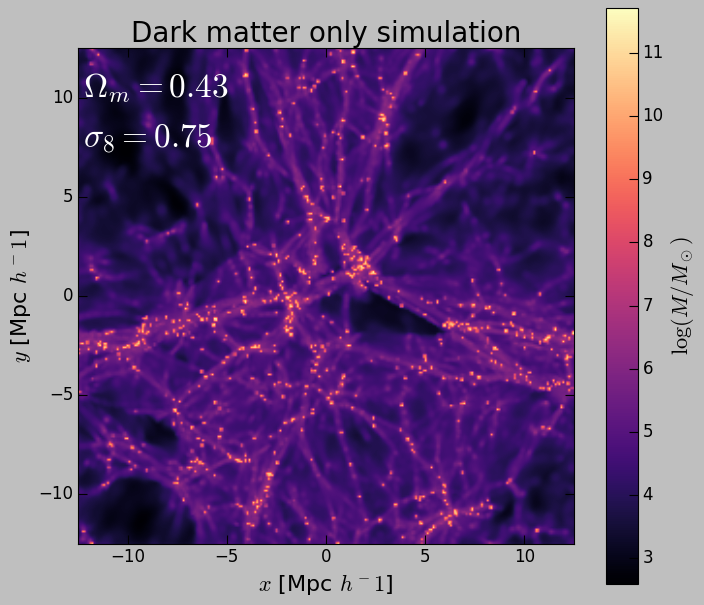

In [14]:
index = 42
cosmo_index = index // 15 # hard coded rule from the data

extent = [-FOV/2,FOV/2] * 2
im = plt.imshow(np.log10(maps[42]), cmap="magma", origin='lower', extent=extent)
plt.title("Dark matter only simulation")
plt.xlabel("$x$ [Mpc $h^-1$]")
plt.ylabel("$y$ [Mpc $h^-1$]")
plt.annotate(r"$\Omega_m = %.2f$" % params[cosmo_index, 0], xy=(0.01, 0.9), xycoords="axes fraction", color="w", fontsize=30)
plt.annotate(r"$\sigma_8= %.2f$" % params[cosmo_index, 1], xy=(0.01, 0.8), xycoords="axes fraction", color="w", fontsize=30)
cax = plt.axes([0.95, 0.05, 0.05, 0.9])
plt.colorbar(mappable=im, cax=cax, label="$\log(M / M_\odot)$");

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Power spectrum')

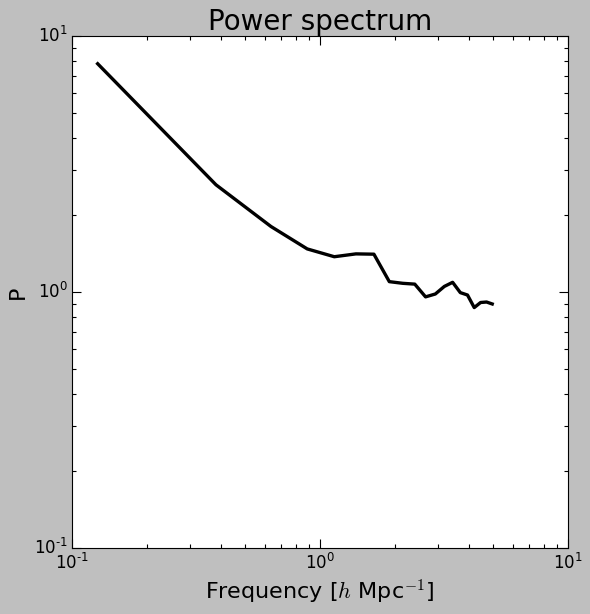

In [13]:
ps = PowerSpectrum(pixels=256, bins=20)
P = ps.power_spectrum(torch.Tensor(maps[42])[None].float().to(DEVICE))[0]

_, f = np.histogram(np.fft.fftfreq(ps.pixels)[:ps.pixels//2], bins=ps.bins)
f = (f[:-1] + f[1:]) / 2 * ps.pixels / FOV
plt.loglog(f, P, "k-", lw=3)
plt.xlabel("Frequency [$h$ Mpc$^{-1}$]")
plt.ylabel("P")
plt.title("Power spectrum")

# Neural network architectures

In [ ]:
# class Unet(nn.Module):
#   def __init__(self):
#       # Make your architecture here
#   def call(self, x):
#     # define the flow of operations here
#     # return y

In [ ]:
# class CNN(nn.Module):
#     def __init__(self):
#         # Make your architecture here
#     def forward(self, image):
#         # define the flow of operations here
#         # return y

# Training loop

In [ ]:
# EPOCHS = 10 # number of loop over the dataset
# TRAIN_SPLIT = 0.9 # fraction of the dataset used for training
# BATCH_SIZE = 10

# dataset = IllustrisFieldtoCosmo(path_to_total_mass_maps, path_to_cosmo_params, crop_size=32)
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# net = ...
# trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

# for epoch in range(EPOCHS):
    # reset your metrics here  
    # running_loss = 0.0 
    # for i, (X, Y) in enumerate(trainloader):

        # zero the parameter gradients
        # optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = net(inputs)
        # loss = criterion(outputs, labels)
        # loss.backward()
        # optimizer.step()

# Results Field to Cosmology

# Results Field to Field
